In [1]:
import sys
ROOT_DIR = ".."
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

In [2]:
import os
import time
import numpy as np
from scipy import stats
import six
import itertools
import h5py as h5
from mpi4py import MPI # module required to use MPI
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import pysingfel as ps
import pysingfel.gpu as pg
from pysingfel.util import asnumpy, xp

In [3]:
beam = ps.Beam(ROOT_DIR+'/input/beam/amo86615.beam')
beam._n_phot *= 100
print "number of photons per shot: ", beam._n_phot

number of photons per shot:  1e+14


In [4]:
det = ps.PnccdDetector(geom=ROOT_DIR+'/input/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data',beam=beam)
det.distance *= 0.3

In [5]:
particle = ps.Particle()
particle.read_pdb(ROOT_DIR+'/input/pdb/2CEX.pdb', ff='WK')

('Unknown element or wrong line: \n', 'HETATM 9529 ZN    ZN A1306      16.516   1.920  -2.897  0.50 39.31          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9562 ZN    ZN B1310      79.517  -6.890  29.691  1.00 30.08          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9563 ZN    ZN B1311      54.463  32.835  14.529  0.50 32.48          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9564 ZN    ZN C1306      14.881  -6.161  50.429  1.00 30.87          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9565 ZN    ZN C1307      22.417 -36.707  14.694  0.50 53.28          ZN  \n')
('Unknown element or wrong line: \n', 'HETATM 9572 ZN    ZN D1307      -6.904  24.013  20.912  0.50 21.13          ZN  \n')


# Monochromatic Beam, SPI

In [6]:
experiment = ps.SPIExperiment(det, beam, particle)

('intensity: ', 3.183098861837907e+27)


In [7]:
def demo(experiment):
    viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)
    img = experiment.generate_image()
    viz.imshow(img)
    plt.show()

('intensity: ', 3.183098861837907e+27)
('counter', 0)
('intensity: ', 3.183098861837907e+27)
('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[2.37479570e+04, 2.73963777e+04, 3.13415620e+04, ...,
         6.14964206e+05, 6.33435246e+05, 6.52151703e+05],
        [2.34020486e+04, 2.70654208e+04, 3.10067556e+04, ...,
         6.27864903e+05, 6.46731707e+05, 6.65851157e+05],
        [2.31170056e+04, 2.67978327e+04, 3.07575747e+04, ...,
         6.41159938e+05, 6.60429032e+05, 6.79958119e+05],
        ...,
        [8.92465736e+05, 8.63190256e+05, 8.34265418e+05, ...,
         4.14687901e+09, 4.17249279e+09, 4.19885732e+09],
        [8.90110785e+05, 8.61241944e+05, 8.32710658e+05, ...,
         4.15788911e+09, 4.18289844e+09, 4.20865639e+09],
        [8.87686084e+05, 8.59224874e+05, 8.31088287e+05, ...,
         4.16780054e+09, 4.19219953e+09, 4.21734496e+09]],

       [[1.80232638e+05, 1.72126809e+05, 1.63006791e+05, ...,
         1.59478468e+05, 1.59984415e+05, 1.605132

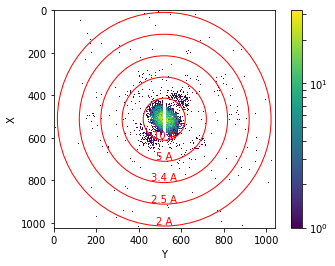

In [8]:
demo(experiment)

# SASE Beam, SPI

In [9]:
Beam = ps.Beam

In [10]:
class MyBeam(Beam):
    def __init__(self, mu=None, sigma=None, n_spikes=0,
                 *args, **kargs):
        super(MyBeam, self).__init__(**kargs)
        self.mu = mu
        self.sigma = sigma
        self.n_spikes = n_spikes
        
    def get_highest_wavenumber_beam(self):
        """
        For variable/polychromatic beam to return highest wavenumber.
        """
        return Beam(
            wavenumber=self.wavenumber*1.5,
            focus_x=self._focus_xFWHM,
            focus_y=self._focus_yFWHM,
            focus_shape=self._focus_shape,
            fluence=self.get_photons_per_pulse()
        )
    
    def generate_new_state(self):
        """
        For variable beam to return specific instance.
        """
        # If simple Beam, return itself.
        # Variable beams should return simple one.
        samples = np.random.normal(mu, sigma, n_spikes*100000)
        
        gkde = stats.gaussian_kde(samples)

        gkde.set_bandwidth(bw_method=0.25)

        xs = np.linspace(self.mu-50, self.mu+50, self.n_spikes+1)

        density, bins, patches = plt.hist(samples, bins=xs, histtype=u'step', density=True)
        
        ind = np.where(density == np.amax(density))
        density[ind[0][0]] *= 1.5
        density_renorm = density / density.sum()
        
        plt.plot(xs, gkde(xs),'r')
        
        photon_energy = np.linspace(self.mu-50, self.mu+50, self.n_spikes+1).tolist()
        fluences = (self.get_photons_per_pulse()*density_renorm/density_renorm.sum())
        
        return [
            Beam(
                photon_energy=photon_energy[i],
                focus_x=self._focus_xFWHM,
                focus_y=self._focus_yFWHM,
                focus_shape=self._focus_shape,
                fluence=fluences[i])
            for i in range(self.n_spikes)
        ]

In [11]:
mu, sigma = 7120, 10 # mean and standard deviation
n_spikes = 100
sase = MyBeam(mu, sigma, n_spikes, fname=ROOT_DIR+'/input/beam/amo86615.beam')
sase._n_phot *= 100
print "number of photons per shot: ", sase._n_phot

number of photons per shot:  1e+14


i: 0 , intensity: 6.241625795639982e+20
i: 1 , intensity: 1.2483251591279964e+21
i: 2 , intensity: 1.8724877386919948e+21
i: 3 , intensity: 3.120812897819991e+20
i: 4 , intensity: 4.057056767165989e+21
i: 5 , intensity: 7.802032244549978e+21
i: 6 , intensity: 8.114113534331978e+21
i: 7 , intensity: 1.5604064489099957e+22
i: 8 , intensity: 2.4030259313213937e+22
i: 9 , intensity: 3.5889348324929896e+22
i: 10 , intensity: 5.430214442206786e+22
i: 11 , intensity: 7.583575341702579e+22
i: 12 , intensity: 1.0142641917914972e+23
i: 13 , intensity: 1.6134602681729356e+23
i: 14 , intensity: 2.228260409043474e+23
i: 15 , intensity: 3.201954033163311e+23
i: 16 , intensity: 4.534541140532447e+23
i: 17 , intensity: 6.419512130815722e+23
i: 18 , intensity: 8.657134978552656e+23
i: 19 , intensity: 1.1849726573022506e+24
i: 20 , intensity: 1.6134602681729353e+24
i: 21 , intensity: 2.149928005308192e+24
i: 22 , intensity: 2.8340101925103344e+24
i: 23 , intensity: 3.737173445139439e+24
i: 24 , intensit

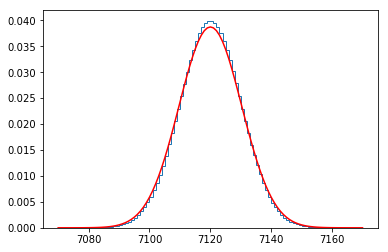

In [12]:
spikes = sase.generate_new_state()
energy = []
flux = []
for i in range(100):
    print "i:", i, ", intensity:", spikes[i].get_photons_per_pulse() / spikes[i].get_focus_area()
    energy.append(spikes[i].photon_energy)
    flux.append(spikes[i].get_photons_per_pulse())
print "flux.sum: ", np.array(flux).sum()
print "nonzero: ", np.count_nonzero(np.array(flux))

In [13]:
experiment = ps.SPIExperiment(det, sase, particle)

('intensity: ', 3.183098861837907e+27)


('intensity: ', 3.183098861837907e+27)
('counter', 0)
('intensity: ', 1.2483174486163886e+21)
('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.12907062e+04, 1.15889817e+04, 1.18915328e+04, ...,
         1.06054688e+04, 1.14436927e+04, 1.23559984e+04],
        [1.09855452e+04, 1.12879587e+04, 1.15945875e+04, ...,
         1.08528017e+04, 1.16776765e+04, 1.25789952e+04],
        [1.07505507e+04, 1.10600879e+04, 1.13738691e+04, ...,
         1.10698339e+04, 1.18788345e+04, 1.27666615e+04],
        ...,
        [1.13577028e+05, 1.17656765e+05, 1.21901259e+05, ...,
         3.79865047e+09, 3.85392731e+09, 3.91115082e+09],
        [1.17024120e+05, 1.21580689e+05, 1.26127074e+05, ...,
         3.82284788e+09, 3.87688490e+09, 3.93285754e+09],
        [1.19338410e+05, 1.23914961e+05, 1.28710870e+05, ...,
         3.84465287e+09, 3.89741857e+09, 3.95210850e+09]],

       [[5.81092557e+04, 5.55221740e+04, 5.30143107e+04, ...,
         1.04495200e+04, 1.23038151e+04, 1.43062

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.12931308e+04, 1.15903170e+04, 1.18917796e+04, ...,
         1.05770240e+04, 1.14183492e+04, 1.23334314e+04],
        [1.09767010e+04, 1.12775775e+04, 1.15826609e+04, ...,
         1.08289985e+04, 1.16573875e+04, 1.25618957e+04],
        [1.07301554e+04, 1.10376957e+04, 1.13494629e+04, ...,
         1.10509235e+04, 1.18638391e+04, 1.27552567e+04],
        ...,
        [1.13004530e+05, 1.17057489e+05, 1.21292172e+05, ...,
         3.79848542e+09, 3.85377390e+09, 3.91101007e+09],
        [1.16370512e+05, 1.20894402e+05, 1.25506967e+05, ...,
         3.82269444e+09, 3.87674244e+09, 3.93272707e+09],
        [1.18682319e+05, 1.23226242e+05, 1.27989144e+05, ...,
         3.84450977e+09, 3.89728577e+09, 3.95198701e+09]],

       [[5.77597241e+04, 5.51681829e+04, 5.26575593e+04, ...,
         1.07110580e+04, 1.25911929e+04, 1.46197405e+04],
        [6.04028422e+04, 5.78219228e+04, 5.53078640e+04, ...,
         1.07696103e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.12974032e+04, 1.15935708e+04, 1.18940165e+04, ...,
         1.05479082e+04, 1.13922671e+04, 1.23100581e+04],
        [1.09698102e+04, 1.12692233e+04, 1.15728361e+04, ...,
         1.08044869e+04, 1.16363244e+04, 1.25439563e+04],
        [1.07118215e+04, 1.10174416e+04, 1.13272725e+04, ...,
         1.10312718e+04, 1.18480389e+04, 1.27429832e+04],
        ...,
        [1.12436330e+05, 1.16462514e+05, 1.20670807e+05, ...,
         3.79832038e+09, 3.85362050e+09, 3.91086932e+09],
        [1.15722183e+05, 1.20213458e+05, 1.24891067e+05, ...,
         3.82254100e+09, 3.87659999e+09, 3.93259662e+09],
        [1.18031502e+05, 1.22542863e+05, 1.27272825e+05, ...,
         3.84436669e+09, 3.89715299e+09, 3.95186554e+09]],

       [[5.74145585e+04, 5.48186803e+04, 5.23053194e+04, ...,
         1.09770481e+04, 1.28829895e+04, 1.49375757e+04],
        [6.00299716e+04, 5.74438912e+04, 5.49267775e+04, ...,
         1.10314576e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13034959e+04, 1.15987147e+04, 1.18982145e+04, ...,
         1.05181273e+04, 1.13654521e+04, 1.22858838e+04],
        [1.09648443e+04, 1.12628671e+04, 1.15650833e+04, ...,
         1.07792721e+04, 1.16144922e+04, 1.25251816e+04],
        [1.06955196e+04, 1.09992956e+04, 1.13072672e+04, ...,
         1.10108834e+04, 1.18314381e+04, 1.27298450e+04],
        ...,
        [1.11872424e+05, 1.15871837e+05, 1.20053362e+05, ...,
         3.79815535e+09, 3.85346710e+09, 3.91072857e+09],
        [1.15079119e+05, 1.19537845e+05, 1.24215209e+05, ...,
         3.82238758e+09, 3.87645755e+09, 3.93246616e+09],
        [1.17385946e+05, 1.21864809e+05, 1.26561897e+05, ...,
         3.84422362e+09, 3.89702022e+09, 3.95174406e+09]],

       [[5.70737165e+04, 5.44736229e+04, 5.19575487e+04, ...,
         1.12474636e+04, 1.31791789e+04, 1.52390797e+04],
        [5.96616839e+04, 5.70705704e+04, 5.45504217e+04, ...,
         1.12978465e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13072272e+04, 1.16057206e+04, 1.19043448e+04, ...,
         1.04876873e+04, 1.13379101e+04, 1.22609142e+04],
        [1.09617750e+04, 1.12584798e+04, 1.15593729e+04, ...,
         1.07533595e+04, 1.15918960e+04, 1.25055764e+04],
        [1.06812205e+04, 1.09832280e+04, 1.12894166e+04, ...,
         1.09897629e+04, 1.18140410e+04, 1.27158460e+04],
        ...,
        [1.11312809e+05, 1.15285453e+05, 1.19440215e+05, ...,
         3.79799032e+09, 3.85331371e+09, 3.91058783e+09],
        [1.14441307e+05, 1.18867546e+05, 1.23512048e+05, ...,
         3.82223417e+09, 3.87631511e+09, 3.93233572e+09],
        [1.16745638e+05, 1.21192065e+05, 1.25856346e+05, ...,
         3.84408056e+09, 3.89688746e+09, 3.95162260e+09]],

       [[5.67371560e+04, 5.41329675e+04, 5.16142053e+04, ...,
         1.15222782e+04, 1.34678027e+04, 1.55339236e+04],
        [5.92979355e+04, 5.67019158e+04, 5.41787532e+04, ...,
         1.15687505e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13052008e+04, 1.16065998e+04, 1.19119104e+04, ...,
         1.04565945e+04, 1.13096469e+04, 1.22351549e+04],
        [1.09605743e+04, 1.12560330e+04, 1.15556755e+04, ...,
         1.07267545e+04, 1.15685410e+04, 1.24851457e+04],
        [1.06688956e+04, 1.09692091e+04, 1.12736906e+04, ...,
         1.09679151e+04, 1.17958521e+04, 1.27009904e+04],
        ...,
        [1.10757480e+05, 1.14703359e+05, 1.18831363e+05, ...,
         3.79782531e+09, 3.85316032e+09, 3.91044709e+09],
        [1.13808732e+05, 1.18202549e+05, 1.22814254e+05, ...,
         3.82208076e+09, 3.87617268e+09, 3.93220528e+09],
        [1.16110563e+05, 1.20524619e+05, 1.25156156e+05, ...,
         3.84393751e+09, 3.89675470e+09, 3.95150114e+09]],

       [[5.64048351e+04, 5.37966713e+04, 5.12752472e+04, ...,
         1.17966646e+04, 1.37447384e+04, 1.58323812e+04],
        [5.89386832e+04, 5.63378832e+04, 5.38117289e+04, ...,
         1.18441433e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13049572e+04, 1.16059226e+04, 1.19108203e+04, ...,
         1.04248549e+04, 1.12806684e+04, 1.22086114e+04],
        [1.09612145e+04, 1.12554980e+04, 1.15539622e+04, ...,
         1.06994626e+04, 1.15444324e+04, 1.24638944e+04],
        [1.06585161e+04, 1.09572099e+04, 1.12600594e+04, ...,
         1.09453448e+04, 1.17768759e+04, 1.26852825e+04],
        ...,
        [1.10206436e+05, 1.14125550e+05, 1.18226802e+05, ...,
         3.79766030e+09, 3.85300694e+09, 3.91030636e+09],
        [1.13181381e+05, 1.17542838e+05, 1.22121813e+05, ...,
         3.82192737e+09, 3.87603027e+09, 3.93207484e+09],
        [1.15480708e+05, 1.19862454e+05, 1.24461314e+05, ...,
         3.84379447e+09, 3.89662196e+09, 3.95137970e+09]],

       [[5.60767119e+04, 5.34646915e+04, 5.09406330e+04, ...,
         1.20557581e+04, 1.40253560e+04, 1.61344124e+04],
        [5.85838839e+04, 5.59784285e+04, 5.34493062e+04, ...,
         1.21239988e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13064593e+04, 1.16070663e+04, 1.19116272e+04, ...,
         1.03924750e+04, 1.12509808e+04, 1.21812898e+04],
        [1.09636681e+04, 1.12568468e+04, 1.15542039e+04, ...,
         1.06714896e+04, 1.15195756e+04, 1.24418276e+04],
        [1.06500537e+04, 1.09472012e+04, 1.12484931e+04, ...,
         1.09220569e+04, 1.17571171e+04, 1.26687266e+04],
        ...,
        [1.09659671e+05, 1.13552024e+05, 1.17626526e+05, ...,
         3.79749529e+09, 3.85285356e+09, 3.91016563e+09],
        [1.12559240e+05, 1.16888400e+05, 1.21434709e+05, ...,
         3.82177399e+09, 3.87588785e+09, 3.93194441e+09],
        [1.14856060e+05, 1.19205558e+05, 1.23771804e+05, ...,
         3.84365145e+09, 3.89648923e+09, 3.95125826e+09]],

       [[5.57527452e+04, 5.31369859e+04, 5.06103212e+04, ...,
         1.23186015e+04, 1.43096150e+04, 1.64399768e+04],
        [5.82334949e+04, 5.56235082e+04, 5.30914423e+04, ...,
         1.24082908e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13140726e+04, 1.16099929e+04, 1.19142929e+04, ...,
         1.03594612e+04, 1.12205902e+04, 1.21531959e+04],
        [1.09673535e+04, 1.12600515e+04, 1.15563723e+04, ...,
         1.06428411e+04, 1.14939760e+04, 1.24189505e+04],
        [1.06434803e+04, 1.09391543e+04, 1.12389625e+04, ...,
         1.08980565e+04, 1.17365804e+04, 1.26513273e+04],
        ...,
        [1.09117184e+05, 1.12982775e+05, 1.17030532e+05, ...,
         3.79733030e+09, 3.85270019e+09, 3.91002490e+09],
        [1.11942295e+05, 1.16239221e+05, 1.20752928e+05, ...,
         3.82162061e+09, 3.87574545e+09, 3.93181399e+09],
        [1.14236604e+05, 1.18553916e+05, 1.23087613e+05, ...,
         3.84350844e+09, 3.89635650e+09, 3.95113682e+09]],

       [[5.54328937e+04, 5.28135123e+04, 5.02842710e+04, ...,
         1.25851542e+04, 1.45974751e+04, 1.67490342e+04],
        [5.78874735e+04, 5.52730785e+04, 5.27380949e+04, ...,
         1.26969931e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13238721e+04, 1.16146653e+04, 1.19187789e+04, ...,
         1.03258200e+04, 1.11895030e+04, 1.21243359e+04],
        [1.09651799e+04, 1.12599990e+04, 1.15604390e+04, ...,
         1.06135230e+04, 1.14676394e+04, 1.23952686e+04],
        [1.06395630e+04, 1.09330408e+04, 1.12314384e+04, ...,
         1.08733488e+04, 1.17152708e+04, 1.26330891e+04],
        ...,
        [1.08578971e+05, 1.12417802e+05, 1.16438817e+05, ...,
         3.79716531e+09, 3.85254682e+09, 3.90988417e+09],
        [1.11330532e+05, 1.15595286e+05, 1.20076456e+05, ...,
         3.82146725e+09, 3.87560305e+09, 3.93168357e+09],
        [1.13622328e+05, 1.17907514e+05, 1.22408726e+05, ...,
         3.84336544e+09, 3.89622379e+09, 3.95101540e+09]],

       [[5.51171164e+04, 5.24942287e+04, 4.99624412e+04, ...,
         1.28553761e+04, 1.48888962e+04, 1.70615445e+04],
        [5.75457775e+04, 5.49270964e+04, 5.23892218e+04, ...,
         1.29900798e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13357799e+04, 1.16210463e+04, 1.19250474e+04, ...,
         1.02915580e+04, 1.11577254e+04, 1.20947157e+04],
        [1.09653720e+04, 1.12551298e+04, 1.15575603e+04, ...,
         1.05835412e+04, 1.14405713e+04, 1.23707871e+04],
        [1.06397868e+04, 1.09288325e+04, 1.12258918e+04, ...,
         1.08479391e+04, 1.16931932e+04, 1.26140167e+04],
        ...,
        [1.08045028e+05, 1.11857099e+05, 1.15851374e+05, ...,
         3.79700033e+09, 3.85239346e+09, 3.90974345e+09],
        [1.10723939e+05, 1.14956581e+05, 1.19405279e+05, ...,
         3.82131390e+09, 3.87546067e+09, 3.93155316e+09],
        [1.13013218e+05, 1.17266339e+05, 1.21735128e+05, ...,
         3.84322245e+09, 3.89609109e+09, 3.95089398e+09]],

       [[5.48053726e+04, 5.21790935e+04, 4.96447914e+04, ...,
         1.31292267e+04, 1.51838381e+04, 1.73774677e+04],
        [5.72083649e+04, 5.45855186e+04, 5.20447811e+04, ...,
         1.32614792e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13497371e+04, 1.16290993e+04, 1.19330609e+04, ...,
         1.02566819e+04, 1.11252641e+04, 1.20643417e+04],
        [1.09678691e+04, 1.12520916e+04, 1.15539937e+04, ...,
         1.05529018e+04, 1.14127775e+04, 1.23455117e+04],
        [1.06424890e+04, 1.09265012e+04, 1.12222942e+04, ...,
         1.08218326e+04, 1.16703527e+04, 1.25941149e+04],
        ...,
        [1.07515353e+05, 1.11300663e+05, 1.15268202e+05, ...,
         3.79683536e+09, 3.85224011e+09, 3.90960274e+09],
        [1.10122501e+05, 1.14323093e+05, 1.18739381e+05, ...,
         3.82116056e+09, 3.87531829e+09, 3.93142276e+09],
        [1.12409260e+05, 1.16630377e+05, 1.21066807e+05, ...,
         3.84307948e+09, 3.89595839e+09, 3.95077257e+09]],

       [[5.44976219e+04, 5.18680653e+04, 4.93312810e+04, ...,
         1.34066661e+04, 1.54822607e+04, 1.76967637e+04],
        [5.68751937e+04, 5.42483025e+04, 5.17047311e+04, ...,
         1.35355032e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13656859e+04, 1.16387878e+04, 1.19427821e+04, ...,
         1.02211987e+04, 1.10921255e+04, 1.20332203e+04],
        [1.09726111e+04, 1.12508469e+04, 1.15522967e+04, ...,
         1.05216110e+04, 1.13842640e+04, 1.23194480e+04],
        [1.06476231e+04, 1.09260194e+04, 1.12206172e+04, ...,
         1.07950349e+04, 1.16467544e+04, 1.25733887e+04],
        ...,
        [1.06928995e+05, 1.10748492e+05, 1.14689296e+05, ...,
         3.79667039e+09, 3.85208676e+09, 3.90946203e+09],
        [1.09526206e+05, 1.13694808e+05, 1.18078750e+05, ...,
         3.82100722e+09, 3.87517591e+09, 3.93129236e+09],
        [1.11810442e+05, 1.15999614e+05, 1.20403746e+05, ...,
         3.84293652e+09, 3.89582571e+09, 3.95065117e+09]],

       [[5.41938240e+04, 5.15611030e+04, 4.90218698e+04, ...,
         1.36876539e+04, 1.57841239e+04, 1.80193927e+04],
        [5.65462223e+04, 5.39154056e+04, 5.13690304e+04, ...,
         1.38132104e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.13835685e+04, 1.16504422e+04, 1.19541741e+04, ...,
         1.01851150e+04, 1.10583164e+04, 1.20013580e+04],
        [1.09795387e+04, 1.12513586e+04, 1.15524313e+04, ...,
         1.04896749e+04, 1.13550368e+04, 1.22926018e+04],
        [1.06450685e+04, 1.09255278e+04, 1.12208326e+04, ...,
         1.07675515e+04, 1.16224038e+04, 1.25518430e+04],
        ...,
        [1.06327006e+05, 1.10200582e+05, 1.14114652e+05, ...,
         3.79650544e+09, 3.85193342e+09, 3.90932132e+09],
        [1.08935041e+05, 1.13071713e+05, 1.17423370e+05, ...,
         3.82085390e+09, 3.87503355e+09, 3.93116196e+09],
        [1.11216752e+05, 1.15374038e+05, 1.19745934e+05, ...,
         3.84279357e+09, 3.89569304e+09, 3.95052978e+09]],

       [[5.38939390e+04, 5.12581655e+04, 4.87165180e+04, ...,
         1.39721503e+04, 1.60893879e+04, 1.83453147e+04],
        [5.62214096e+04, 5.35867854e+04, 5.10376376e+04, ...,
         1.40945606e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.14033282e+04, 1.16685692e+04, 1.19672004e+04, ...,
         1.01484381e+04, 1.10238436e+04, 1.19687612e+04],
        [1.09885928e+04, 1.12546131e+04, 1.15543599e+04, ...,
         1.04571000e+04, 1.13251019e+04, 1.22649789e+04],
        [1.06425134e+04, 1.09165805e+04, 1.12171369e+04, ...,
         1.07393881e+04, 1.15973061e+04, 1.25294831e+04],
        ...,
        [1.05730269e+05, 1.09656929e+05, 1.13544267e+05, ...,
         3.79634049e+09, 3.85178008e+09, 3.90918061e+09],
        [1.08348992e+05, 1.12453794e+05, 1.16773228e+05, ...,
         3.82070059e+09, 3.87489119e+09, 3.93103158e+09],
        [1.10628174e+05, 1.14753634e+05, 1.19093355e+05, ...,
         3.84265063e+09, 3.89556038e+09, 3.95040839e+09]],

       [[5.35979270e+04, 5.09592122e+04, 4.84151857e+04, ...,
         1.42601152e+04, 1.63980128e+04, 1.86744900e+04],
        [5.59007142e+04, 5.32624001e+04, 5.07105117e+04, ...,
         1.43795136e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.14249087e+04, 1.16886322e+04, 1.19818247e+04, ...,
         1.01111750e+04, 1.09887139e+04, 1.19354366e+04],
        [1.09997151e+04, 1.12634629e+04, 1.15580451e+04, ...,
         1.04238927e+04, 1.12944656e+04, 1.22365852e+04],
        [1.06422795e+04, 1.09109526e+04, 1.12093122e+04, ...,
         1.07105505e+04, 1.15714670e+04, 1.25063142e+04],
        ...,
        [1.05138767e+05, 1.09117531e+05, 1.12978136e+05, ...,
         3.79617555e+09, 3.85162675e+09, 3.90903991e+09],
        [1.07768047e+05, 1.11841037e+05, 1.16128310e+05, ...,
         3.82054729e+09, 3.87474885e+09, 3.93090119e+09],
        [1.10044698e+05, 1.14138389e+05, 1.18445996e+05, ...,
         3.84250771e+09, 3.89542772e+09, 3.95028701e+09]],

       [[5.33057485e+04, 5.06642027e+04, 4.81178335e+04, ...,
         1.45515088e+04, 1.67099587e+04, 1.90068788e+04],
        [5.55840954e+04, 5.29422076e+04, 5.03876120e+04, ...,
         1.46680294e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.14482541e+04, 1.17105742e+04, 1.19980113e+04, ...,
         1.00733329e+04, 1.09529344e+04, 1.19013911e+04],
        [1.10128479e+04, 1.12744446e+04, 1.15634500e+04, ...,
         1.03900595e+04, 1.12631341e+04, 1.22074269e+04],
        [1.06443070e+04, 1.09100505e+04, 1.12033678e+04, ...,
         1.06810445e+04, 1.15448919e+04, 1.24823415e+04],
        ...,
        [1.04552486e+05, 1.08582384e+05, 1.12416258e+05, ...,
         3.79601061e+09, 3.85147342e+09, 3.90889921e+09],
        [1.07192192e+05, 1.11233429e+05, 1.15488602e+05, ...,
         3.82039400e+09, 3.87460651e+09, 3.93077082e+09],
        [1.09466311e+05, 1.13528290e+05, 1.17803843e+05, ...,
         3.84236480e+09, 3.89529508e+09, 3.95016564e+09]],

       [[5.30173644e+04, 5.03730968e+04, 4.78244220e+04, ...,
         1.48462913e+04, 1.70251859e+04, 1.93424415e+04],
        [5.52715126e+04, 5.26261666e+04, 5.00688979e+04, ...,
         1.49600678e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.14733096e+04, 1.17343384e+04, 1.20157244e+04, ...,
         1.00349191e+04, 1.09165121e+04, 1.18666315e+04],
        [1.10279341e+04, 1.12874994e+04, 1.15705380e+04, ...,
         1.03556071e+04, 1.12311140e+04, 1.21775102e+04],
        [1.06485369e+04, 1.09114777e+04, 1.11992659e+04, ...,
         1.06508762e+04, 1.15175867e+04, 1.24575707e+04],
        ...,
        [1.03971409e+05, 1.07998434e+05, 1.11858627e+05, ...,
         3.79584568e+09, 3.85132010e+09, 3.90875852e+09],
        [1.06621416e+05, 1.10630957e+05, 1.14854091e+05, ...,
         3.82024071e+09, 3.87446417e+09, 3.93064045e+09],
        [1.08892999e+05, 1.12923324e+05, 1.17166883e+05, ...,
         3.84222190e+09, 3.89516244e+09, 3.95004428e+09]],

       [[5.27327355e+04, 5.00858544e+04, 4.75349123e+04, ...,
         1.51414552e+04, 1.73436547e+04, 1.96811384e+04],
        [5.49629253e+04, 5.23142356e+04, 4.97543289e+04, ...,
         1.52555891e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.15000206e+04, 1.17598688e+04, 1.20349290e+04, ...,
         9.99594098e+03, 1.08794542e+04, 1.18311648e+04],
        [1.10449170e+04, 1.13025693e+04, 1.15792727e+04, ...,
         1.03205422e+04, 1.11984116e+04, 1.21468413e+04],
        [1.06549105e+04, 1.09151744e+04, 1.11969690e+04, ...,
         1.06200515e+04, 1.14895572e+04, 1.24320072e+04],
        ...,
        [1.03395523e+05, 1.07390207e+05, 1.11305241e+05, ...,
         3.79568077e+09, 3.85116678e+09, 3.90861783e+09],
        [1.06055704e+05, 1.10033607e+05, 1.14224762e+05, ...,
         3.82008744e+09, 3.87432185e+09, 3.93051008e+09],
        [1.08324750e+05, 1.12323478e+05, 1.16535103e+05, ...,
         3.84207901e+09, 3.89502982e+09, 3.94992293e+09]],

       [[5.24518231e+04, 4.98024360e+04, 4.72492653e+04, ...,
         1.54267606e+04, 1.76653255e+04, 2.00229300e+04],
        [5.46582934e+04, 5.20063736e+04, 4.94438651e+04, ...,
         1.55545533e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.15283333e+04, 1.17871101e+04, 1.20563245e+04, ...,
         9.95640606e+03, 1.08417680e+04, 1.17949981e+04],
        [1.10637408e+04, 1.13195969e+04, 1.15896180e+04, ...,
         1.02848717e+04, 1.11650336e+04, 1.21154265e+04],
        [1.06633699e+04, 1.09210809e+04, 1.11964402e+04, ...,
         1.05885766e+04, 1.14608092e+04, 1.24056568e+04],
        ...,
        [1.02824811e+05, 1.06787226e+05, 1.10756097e+05, ...,
         3.79551585e+09, 3.85101347e+09, 3.90847714e+09],
        [1.05486624e+05, 1.09441368e+05, 1.13600603e+05, ...,
         3.81993418e+09, 3.87417953e+09, 3.93037972e+09],
        [1.07761551e+05, 1.11728739e+05, 1.15908488e+05, ...,
         3.84193613e+09, 3.89489721e+09, 3.94980158e+09]],

       [[5.21745886e+04, 4.95228020e+04, 4.69674427e+04, ...,
         1.57150161e+04, 1.79801150e+04, 2.03677767e+04],
        [5.43575769e+04, 5.17025397e+04, 4.91374665e+04, ...,
         1.58569206e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.15581944e+04, 1.18160075e+04, 1.20842839e+04, ...,
         9.91632191e+03, 1.08034608e+04, 1.17581385e+04],
        [1.10843501e+04, 1.13385252e+04, 1.16030434e+04, ...,
         1.02486024e+04, 1.11309867e+04, 1.20832724e+04],
        [1.06738577e+04, 1.09291386e+04, 1.11976427e+04, ...,
         1.05564578e+04, 1.14313488e+04, 1.23785251e+04],
        ...,
        [1.02259258e+05, 1.06189475e+05, 1.10211191e+05, ...,
         3.79535095e+09, 3.85086017e+09, 3.90833646e+09],
        [1.04916050e+05, 1.08854225e+05, 1.12981600e+05, ...,
         3.81978093e+09, 3.87403722e+09, 3.93024937e+09],
        [1.07203392e+05, 1.11139094e+05, 1.15287026e+05, ...,
         3.84179327e+09, 3.89476460e+09, 3.94968024e+09]],

       [[5.19009938e+04, 4.92469132e+04, 4.66894059e+04, ...,
         1.60061700e+04, 1.82889562e+04, 2.07156392e+04],
        [5.40607363e+04, 5.14026933e+04, 4.88350933e+04, ...,
         1.61626513e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.15895514e+04, 1.18465068e+04, 1.21139532e+04, ...,
         9.87569621e+03, 1.07645403e+04, 1.17205933e+04],
        [1.11066902e+04, 1.13592981e+04, 1.16222574e+04, ...,
         1.02117414e+04, 1.10962777e+04, 1.20503856e+04],
        [1.06863171e+04, 1.09392891e+04, 1.12026694e+04, ...,
         1.05237016e+04, 1.14011821e+04, 1.23506182e+04],
        ...,
        [1.01698850e+05, 1.05596939e+05, 1.09670520e+05, ...,
         3.79518605e+09, 3.85070687e+09, 3.90819578e+09],
        [1.04350637e+05, 1.08272166e+05, 1.12367740e+05, ...,
         3.81962769e+09, 3.87389492e+09, 3.93011903e+09],
        [1.06650258e+05, 1.10554531e+05, 1.14670703e+05, ...,
         3.84165042e+09, 3.89463201e+09, 3.94955891e+09]],

       [[5.16310005e+04, 4.89747307e+04, 4.64151168e+04, ...,
         1.63001708e+04, 1.86004964e+04, 2.10470762e+04],
        [5.37677320e+04, 5.11067941e+04, 4.85367063e+04, ...,
         1.64717057e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.16223524e+04, 1.18785544e+04, 1.21452772e+04, ...,
         9.83453672e+03, 1.07250138e+04, 1.16823699e+04],
        [1.11307069e+04, 1.13818599e+04, 1.16433744e+04, ...,
         1.01742959e+04, 1.10609136e+04, 1.20167728e+04],
        [1.07006918e+04, 1.09514747e+04, 1.12126572e+04, ...,
         1.04903142e+04, 1.13703153e+04, 1.23219419e+04],
        ...,
        [1.01143571e+05, 1.05009602e+05, 1.09090880e+05, ...,
         3.79502117e+09, 3.85055357e+09, 3.90805510e+09],
        [1.03790370e+05, 1.07694580e+05, 1.11759008e+05, ...,
         3.81947446e+09, 3.87375263e+09, 3.92998868e+09],
        [1.06102138e+05, 1.09975036e+05, 1.14059507e+05, ...,
         3.84150758e+09, 3.89449943e+09, 3.94943759e+09]],

       [[5.13645710e+04, 4.87062156e+04, 4.61445375e+04, ...,
         1.65969672e+04, 1.89146847e+04, 2.13784597e+04],
        [5.34785250e+04, 5.08148020e+04, 4.82422660e+04, ...,
         1.67840442e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.16565459e+04, 1.19120976e+04, 1.21782015e+04, ...,
         9.79285131e+03, 1.06848891e+04, 1.16434758e+04],
        [1.11563467e+04, 1.14061555e+04, 1.16663379e+04, ...,
         1.01362730e+04, 1.10249012e+04, 1.19824407e+04],
        [1.07169262e+04, 1.09656383e+04, 1.12247432e+04, ...,
         1.04563024e+04, 1.13387548e+04, 1.22925024e+04],
        ...,
        [1.00593407e+05, 1.04427450e+05, 1.08476333e+05, ...,
         3.79485628e+09, 3.85040029e+09, 3.90791443e+09],
        [1.03235234e+05, 1.07107369e+05, 1.11155394e+05, ...,
         3.81932123e+09, 3.87361034e+09, 3.92985835e+09],
        [1.05559020e+05, 1.09400598e+05, 1.13453424e+05, ...,
         3.84136476e+09, 3.89436685e+09, 3.94931627e+09]],

       [[5.11016676e+04, 4.84413296e+04, 4.58776303e+04, ...,
         1.68965082e+04, 1.92314705e+04, 2.17122932e+04],
        [5.31930762e+04, 5.05266770e+04, 4.79517336e+04, ...,
         1.70996273e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.16920814e+04, 1.19470839e+04, 1.22126722e+04, ...,
         9.75064792e+03, 1.06441740e+04, 1.16039185e+04],
        [1.11835567e+04, 1.14321305e+04, 1.16910918e+04, ...,
         1.00976800e+04, 1.09882478e+04, 1.19473962e+04],
        [1.07349654e+04, 1.09817234e+04, 1.12388693e+04, ...,
         1.04216727e+04, 1.13065070e+04, 1.22623059e+04],
        ...,
        [1.00048343e+05, 1.03850465e+05, 1.07867026e+05, ...,
         3.79469141e+09, 3.85024700e+09, 3.90777376e+09],
        [1.02685215e+05, 1.06525342e+05, 1.10556882e+05, ...,
         3.81916802e+09, 3.87346806e+09, 3.92972802e+09],
        [1.05020892e+05, 1.08831204e+05, 1.12852441e+05, ...,
         3.84122194e+09, 3.89423429e+09, 3.94919496e+09]],

       [[5.08422530e+04, 4.81800343e+04, 4.56143578e+04, ...,
         1.71987432e+04, 1.95508034e+04, 2.20485268e+04],
        [5.29113469e+04, 5.02423796e+04, 4.76650703e+04, ...,
         1.74184155e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.17289088e+04, 1.19834618e+04, 1.22486361e+04, ...,
         9.70793460e+03, 1.06028763e+04, 1.15637058e+04],
        [1.12122847e+04, 1.14597310e+04, 1.17175807e+04, ...,
         1.00585244e+04, 1.09509604e+04, 1.19116464e+04],
        [1.07547548e+04, 1.09996741e+04, 1.12549781e+04, ...,
         1.03864319e+04, 1.12735784e+04, 1.22313586e+04],
        ...,
        [9.95083637e+04, 1.03278635e+05, 1.07262944e+05, ...,
         3.79452654e+09, 3.85009373e+09, 3.90763309e+09],
        [1.02140299e+05, 1.05948486e+05, 1.09963460e+05, ...,
         3.81901482e+09, 3.87332579e+09, 3.92959770e+09],
        [1.04487743e+05, 1.08266841e+05, 1.12256546e+05, ...,
         3.84107914e+09, 3.89410173e+09, 3.94907366e+09]],

       [[5.05862901e+04, 4.79222917e+04, 4.53546826e+04, ...,
         1.75036216e+04, 1.98726331e+04, 2.23871106e+04],
        [5.26332986e+04, 4.99618703e+04, 4.73822375e+04, ...,
         1.77403694e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.17669786e+04, 1.20211802e+04, 1.22860404e+04, ...,
         9.66471948e+03, 1.05610039e+04, 1.15228454e+04],
        [1.12424789e+04, 1.14889039e+04, 1.17457500e+04, ...,
         1.00188137e+04, 1.09130465e+04, 1.18751983e+04],
        [1.07762407e+04, 1.10194351e+04, 1.12730127e+04, ...,
         1.03505869e+04, 1.12399756e+04, 1.21996670e+04],
        ...,
        [9.89734558e+04, 1.02711943e+05, 1.06664071e+05, ...,
         3.79436169e+09, 3.84994045e+09, 3.90749243e+09],
        [1.01600471e+05, 1.05376785e+05, 1.09367328e+05, ...,
         3.81886163e+09, 3.87318353e+09, 3.92946738e+09],
        [1.03959559e+05, 1.07707498e+05, 1.11665726e+05, ...,
         3.84093635e+09, 3.89396919e+09, 3.94895237e+09]],

       [[5.03337421e+04, 4.76680642e+04, 4.50985678e+04, ...,
         1.78110931e+04, 2.01969097e+04, 2.27279948e+04],
        [5.23588932e+04, 4.96851101e+04, 4.71031969e+04, ...,
         1.80654496e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.18062423e+04, 1.20601887e+04, 1.23248333e+04, ...,
         9.62101079e+03, 1.05185649e+04, 1.14813451e+04],
        [1.12740884e+04, 1.15195966e+04, 1.17755454e+04, ...,
         9.97855536e+03, 1.08745134e+04, 1.18380591e+04],
        [1.07993698e+04, 1.10409516e+04, 1.12929170e+04, ...,
         1.03141445e+04, 1.12057054e+04, 1.21672376e+04],
        ...,
        [9.84436043e+04, 1.02150376e+05, 1.06070392e+05, ...,
         3.79419684e+09, 3.84978719e+09, 3.90735177e+09],
        [1.01065716e+05, 1.04810224e+05, 1.08768570e+05, ...,
         3.81870845e+09, 3.87304128e+09, 3.92933707e+09],
        [1.03436330e+05, 1.07153162e+05, 1.11079968e+05, ...,
         3.84079357e+09, 3.89383666e+09, 3.94883108e+09]],

       [[5.00845723e+04, 4.74173141e+04, 4.48459765e+04, ...,
         1.81211076e+04, 2.05235834e+04, 2.30711300e+04],
        [5.20880925e+04, 4.94120599e+04, 4.68279104e+04, ...,
         1.83888509e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.18466516e+04, 1.21004378e+04, 1.23649634e+04, ...,
         9.57681685e+03, 1.04755675e+04, 1.14392130e+04],
        [1.13070628e+04, 1.15517571e+04, 1.18069134e+04, ...,
         9.93775719e+03, 1.08353686e+04, 1.18002361e+04],
        [1.08240895e+04, 1.10641695e+04, 1.13146353e+04, ...,
         1.02771119e+04, 1.11707745e+04, 1.21340769e+04],
        ...,
        [9.79187951e+04, 1.01593917e+05, 1.05481892e+05, ...,
         3.79403199e+09, 3.84963393e+09, 3.90721112e+09],
        [1.00536021e+05, 1.04248789e+05, 1.08175006e+05, ...,
         3.81855528e+09, 3.87289903e+09, 3.92920676e+09],
        [1.02918044e+05, 1.06603821e+05, 1.10499260e+05, ...,
         3.84065081e+09, 3.89370413e+09, 3.94870981e+09]],

       [[4.98387443e+04, 4.71700041e+04, 4.45968723e+04, ...,
         1.84336152e+04, 2.08526046e+04, 2.34164671e+04],
        [5.18208590e+04, 4.91426811e+04, 4.65563401e+04, ...,
         1.87010487e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.18881592e+04, 1.21418782e+04, 1.24063800e+04, ...,
         9.53214605e+03, 1.04320198e+04, 1.13964570e+04],
        [1.13413524e+04, 1.15853340e+04, 1.18398012e+04, ...,
         9.89642692e+03, 1.07956196e+04, 1.17617368e+04],
        [1.08503479e+04, 1.10890353e+04, 1.13381126e+04, ...,
         1.02394962e+04, 1.11351900e+04, 1.21001918e+04],
        ...,
        [9.73990140e+04, 1.01042552e+05, 1.04898555e+05, ...,
         3.79386716e+09, 3.84948067e+09, 3.90707047e+09],
        [1.00011371e+05, 1.03692464e+05, 1.07586622e+05, ...,
         3.81840212e+09, 3.87275680e+09, 3.92907646e+09],
        [1.02404690e+05, 1.06059463e+05, 1.09923589e+05, ...,
         3.84050806e+09, 3.89357162e+09, 3.94858854e+09]],

       [[4.95962220e+04, 4.69260973e+04, 4.43512188e+04, ...,
         1.87485664e+04, 2.11839241e+04, 2.37639569e+04],
        [5.15571550e+04, 4.88769354e+04, 4.62884485e+04, ...,
         1.90158652e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.19307183e+04, 1.21844616e+04, 1.24490329e+04, ...,
         9.48700689e+03, 1.03879303e+04, 1.13530854e+04],
        [1.13769080e+04, 1.16202768e+04, 1.18741563e+04, ...,
         9.85457242e+03, 1.07552742e+04, 1.17225685e+04],
        [1.08780936e+04, 1.11154961e+04, 1.13632944e+04, ...,
         1.02013045e+04, 1.10989587e+04, 1.20655889e+04],
        ...,
        [9.68842468e+04, 1.00496267e+05, 1.04320366e+05, ...,
         3.79370233e+09, 3.84932742e+09, 3.90692982e+09],
        [9.94917532e+04, 1.03141237e+05, 1.07003402e+05, ...,
         3.81824897e+09, 3.87261456e+09, 3.92894617e+09],
        [1.01896256e+05, 1.05520076e+05, 1.09352944e+05, ...,
         3.84036532e+09, 3.89343911e+09, 3.94846728e+09]],

       [[4.93569696e+04, 4.66855568e+04, 4.41089798e+04, ...,
         1.90659117e+04, 2.15174928e+04, 2.41135505e+04],
        [5.12969432e+04, 4.86147844e+04, 4.60241979e+04, ...,
         1.93332503e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.19742827e+04, 1.22281402e+04, 1.24928729e+04, ...,
         9.44140796e+03, 1.03433072e+04, 1.13091065e+04],
        [1.14136811e+04, 1.16565353e+04, 1.19099272e+04, ...,
         9.81220165e+03, 1.07143400e+04, 1.16827389e+04],
        [1.09072759e+04, 1.11434996e+04, 1.13901269e+04, ...,
         1.01625442e+04, 1.10620879e+04, 1.20302752e+04],
        ...,
        [9.60633492e+04, 9.99550480e+04, 1.03747311e+05, ...,
         3.79353751e+09, 3.84917418e+09, 3.90678918e+09],
        [9.89434917e+04, 1.02595091e+05, 1.06425332e+05, ...,
         3.81809583e+09, 3.87247234e+09, 3.92881588e+09],
        [1.01392732e+05, 1.04985649e+05, 1.08787311e+05, ...,
         3.84022259e+09, 3.89330662e+09, 3.94834602e+09]],

       [[4.91209512e+04, 4.64483461e+04, 4.38701195e+04, ...,
         1.93856020e+04, 2.18532616e+04, 2.44651995e+04],
        [5.10401867e+04, 4.83561903e+04, 4.57635514e+04, ...,
         1.96531537e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.20188072e+04, 1.22728670e+04, 1.25378512e+04, ...,
         9.39535792e+03, 1.02981592e+04, 1.12645284e+04],
        [1.14516240e+04, 1.16940600e+04, 1.19470628e+04, ...,
         9.76932266e+03, 1.06728251e+04, 1.16422557e+04],
        [1.09378446e+04, 1.11729941e+04, 1.14185569e+04, ...,
         1.01232228e+04, 1.10245847e+04, 1.19942577e+04],
        ...,
        [9.51655803e+04, 9.94188793e+04, 1.03179374e+05, ...,
         3.79337270e+09, 3.84902094e+09, 3.90664854e+09],
        [9.80248103e+04, 1.02054014e+05, 1.05852396e+05, ...,
         3.81794270e+09, 3.87233013e+09, 3.92868560e+09],
        [1.00734746e+05, 1.04456170e+05, 1.08226678e+05, ...,
         3.84007988e+09, 3.89317413e+09, 3.94822478e+09]],

       [[4.88881315e+04, 4.62144288e+04, 4.36346022e+04, ...,
         1.97075882e+04, 2.21911819e+04, 2.48188553e+04],
        [5.07868485e+04, 4.81011154e+04, 4.55064718e+04, ...,
         1.99755256e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.20642468e+04, 1.23185954e+04, 1.25839196e+04, ...,
         9.34886554e+03, 1.02524948e+04, 1.12193598e+04],
        [1.14906895e+04, 1.17328023e+04, 1.19855128e+04, ...,
         9.72594358e+03, 1.06307373e+04, 1.16011266e+04],
        [1.09697502e+04, 1.12039287e+04, 1.14485318e+04, ...,
         1.00833477e+04, 1.09864564e+04, 1.19575435e+04],
        ...,
        [9.42743722e+04, 9.88877472e+04, 1.02616540e+05, ...,
         3.79320789e+09, 3.84886771e+09, 3.90650791e+09],
        [9.71128178e+04, 1.01517990e+05, 1.05284581e+05, ...,
         3.81778958e+09, 3.87218792e+09, 3.92855532e+09],
        [9.98179470e+04, 1.03931627e+05, 1.07671034e+05, ...,
         3.83993717e+09, 3.89304166e+09, 3.94810354e+09]],

       [[4.86584754e+04, 4.59837690e+04, 4.34023926e+04, ...,
         2.00318216e+04, 2.25312053e+04, 2.51744698e+04],
        [5.05368923e+04, 4.78495221e+04, 4.52529225e+04, ...,
         2.03003163e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.21105577e+04, 1.23652799e+04, 1.26310307e+04, ...,
         9.30193965e+03, 1.02063226e+04, 1.11736091e+04],
        [1.15308311e+04, 1.17727139e+04, 1.20252273e+04, ...,
         9.68207263e+03, 1.05880847e+04, 1.15593596e+04],
        [1.10029439e+04, 1.12362529e+04, 1.14799996e+04, ...,
         1.00429265e+04, 1.09477105e+04, 1.19201398e+04],
        ...,
        [9.33897047e+04, 9.83616376e+04, 1.02058796e+05, ...,
         3.79304309e+09, 3.84871448e+09, 3.90636727e+09],
        [9.62074942e+04, 1.00987006e+05, 1.04721871e+05, ...,
         3.81763647e+09, 3.87204572e+09, 3.92842505e+09],
        [9.89076319e+04, 1.03412009e+05, 1.07120367e+05, ...,
         3.83979448e+09, 3.89290920e+09, 3.94798231e+09]],

       [[4.84319478e+04, 4.57563307e+04, 4.31734553e+04, ...,
         2.03582536e+04, 2.28732834e+04, 2.55319948e+04],
        [5.02902815e+04, 4.76013733e+04, 4.50028670e+04, ...,
         2.06274763e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.21576962e+04, 1.24128751e+04, 1.26683750e+04, ...,
         9.25458919e+03, 1.01596516e+04, 1.11272849e+04],
        [1.15720030e+04, 1.18137475e+04, 1.20661573e+04, ...,
         9.63771815e+03, 1.05448754e+04, 1.15169625e+04],
        [1.10373776e+04, 1.12699169e+04, 1.15129090e+04, ...,
         1.00019669e+04, 1.09083543e+04, 1.18820540e+04],
        ...,
        [9.25115579e+04, 9.78405363e+04, 1.01506126e+05, ...,
         3.79287831e+09, 3.84856126e+09, 3.90622665e+09],
        [9.53088197e+04, 1.00461049e+05, 1.04164252e+05, ...,
         3.81748337e+09, 3.87190353e+09, 3.92829479e+09],
        [9.80037838e+04, 1.02897304e+05, 1.06574664e+05, ...,
         3.83965181e+09, 3.89277674e+09, 3.94786108e+09]],

       [[4.82085141e+04, 4.55320784e+04, 4.29477555e+04, ...,
         2.06868358e+04, 2.32173681e+04, 2.58913825e+04],
        [5.00469802e+04, 4.73566320e+04, 4.47562688e+04, ...,
         2.09569564e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.22056198e+04, 1.24613369e+04, 1.26822330e+04, ...,
         9.20682318e+03, 1.01124905e+04, 1.10803961e+04],
        [1.16141599e+04, 1.18558562e+04, 1.21082543e+04, ...,
         9.59288853e+03, 1.05011176e+04, 1.14739436e+04],
        [1.10730036e+04, 1.13048715e+04, 1.15472092e+04, ...,
         9.96047670e+03, 1.08683956e+04, 1.18432933e+04],
        ...,
        [9.16399120e+04, 9.73244294e+04, 1.00958515e+05, ...,
         3.79271352e+09, 3.84840804e+09, 3.90608602e+09],
        [9.44167744e+04, 9.99401026e+04, 1.03611710e+05, ...,
         3.81733028e+09, 3.87176135e+09, 3.92816453e+09],
        [9.71063863e+04, 1.02387502e+05, 1.06033915e+05, ...,
         3.83950914e+09, 3.89264430e+09, 3.94773987e+09]],

       [[4.79881397e+04, 4.53109767e+04, 4.27252584e+04, ...,
         2.10175202e+04, 2.35634115e+04, 2.62525854e+04],
        [4.98069524e+04, 4.71152615e+04, 4.45130921e+04, ...,
         2.12887075e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.22542864e+04, 1.25106213e+04, 1.26963882e+04, ...,
         9.15865072e+03, 1.00648484e+04, 1.10329513e+04],
        [1.16572574e+04, 1.18989938e+04, 1.21514704e+04, ...,
         9.54759227e+03, 1.04568198e+04, 1.14303108e+04],
        [1.11097750e+04, 1.13410683e+04, 1.15828501e+04, ...,
         9.91846375e+03, 1.08278420e+04, 1.18038654e+04],
        ...,
        [9.07747471e+04, 9.68133030e+04, 1.00415951e+05, ...,
         3.79254875e+09, 3.84825483e+09, 3.90594540e+09],
        [9.35313386e+04, 9.94241549e+04, 1.03064230e+05, ...,
         3.81717720e+09, 3.87161917e+09, 3.92803428e+09],
        [9.62154230e+04, 1.01882590e+05, 1.05498106e+05, ...,
         3.83936649e+09, 3.89251186e+09, 3.94761866e+09]],

       [[4.77707906e+04, 4.50929905e+04, 4.25059295e+04, ...,
         2.13502588e+04, 2.39113660e+04, 2.66155559e+04],
        [4.95701626e+04, 4.68772252e+04, 4.42733009e+04, ...,
         2.16226809e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.23036548e+04, 1.25541745e+04, 1.27108020e+04, ...,
         9.11008101e+03, 1.00167341e+04, 1.09849596e+04],
        [1.17012516e+04, 1.19431148e+04, 1.21957587e+04, ...,
         9.50183795e+03, 1.04119903e+04, 1.13860725e+04],
        [1.11476455e+04, 1.13784594e+04, 1.16197823e+04, ...,
         9.87593602e+03, 1.07867012e+04, 1.17637777e+04],
        ...,
        [8.99160438e+04, 9.59497147e+04, 9.98784169e+04, ...,
         3.79238398e+09, 3.84810162e+09, 3.90580478e+09],
        [9.26524927e+04, 9.88317353e+04, 1.02521799e+05, ...,
         3.81702413e+09, 3.87147701e+09, 3.92790403e+09],
        [9.53308775e+04, 1.01382558e+05, 1.04967228e+05, ...,
         3.83922384e+09, 3.89237944e+09, 3.94749746e+09]],

       [[4.75564326e+04, 4.48780850e+04, 4.22897344e+04, ...,
         2.16850038e+04, 2.42611840e+04, 2.69306847e+04],
        [4.93365754e+04, 4.66424868e+04, 4.40368596e+04, ...,
         2.19588278e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.23536841e+04, 1.25686015e+04, 1.27254363e+04, ...,
         9.06112332e+03, 9.96815701e+03, 1.09364298e+04],
        [1.17460993e+04, 1.19881744e+04, 1.22410724e+04, ...,
         9.45563423e+03, 1.03666376e+04, 1.13412371e+04],
        [1.11865696e+04, 1.14169976e+04, 1.16579569e+04, ...,
         9.83290155e+03, 1.07449812e+04, 1.17230381e+04],
        ...,
        [8.90637825e+04, 9.50566958e+04, 9.93459003e+04, ...,
         3.79221922e+09, 3.84794843e+09, 3.90566417e+09],
        [9.17802173e+04, 9.79178616e+04, 1.01984402e+05, ...,
         3.81687107e+09, 3.87133485e+09, 3.92777379e+09],
        [9.44527338e+04, 1.00679933e+05, 1.04441267e+05, ...,
         3.83908122e+09, 3.89224702e+09, 3.94737627e+09]],

       [[4.73450320e+04, 4.46662255e+04, 4.20766392e+04, ...,
         2.20217076e+04, 2.46128181e+04, 2.71788351e+04],
        [4.91061556e+04, 4.64110104e+04, 4.38037328e+04, ...,
         2.22970999e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.24043347e+04, 1.25831444e+04, 1.27402538e+04, ...,
         9.01178701e+03, 9.91912620e+03, 1.08873712e+04],
        [1.17917580e+04, 1.20341284e+04, 1.22873659e+04, ...,
         9.40898989e+03, 1.03207703e+04, 1.12958130e+04],
        [1.12265022e+04, 1.14566363e+04, 1.16973257e+04, ...,
         9.78936848e+03, 1.07026899e+04, 1.16816543e+04],
        ...,
        [8.82179437e+04, 9.41701866e+04, 9.88183867e+04, ...,
         3.79205447e+09, 3.84779523e+09, 3.90552356e+09],
        [9.09144929e+04, 9.70106257e+04, 1.01452025e+05, ...,
         3.81671802e+09, 3.87119269e+09, 3.92764355e+09],
        [9.35809757e+04, 9.97674369e+04, 1.03920213e+05, ...,
         3.83893860e+09, 3.89211462e+09, 3.94725509e+09]],

       [[4.71365553e+04, 4.44573777e+04, 4.18666099e+04, ...,
         2.23603229e+04, 2.49662214e+04, 2.74275535e+04],
        [4.88788684e+04, 4.61827602e+04, 4.35738854e+04, ...,
         2.26374490e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.24537266e+04, 1.25977683e+04, 1.27552181e+04, ...,
         8.96208152e+03, 9.86965101e+03, 1.08377928e+04],
        [1.18381861e+04, 1.20809334e+04, 1.23345939e+04, ...,
         9.36191375e+03, 1.02743971e+04, 1.12498086e+04],
        [1.12673991e+04, 1.14973295e+04, 1.17378412e+04, ...,
         9.74534505e+03, 1.06598353e+04, 1.16396341e+04],
        ...,
        [8.73785081e+04, 9.32901675e+04, 9.82958621e+04, ...,
         3.79188973e+09, 3.84764204e+09, 3.90538295e+09],
        [9.00553002e+04, 9.61100077e+04, 1.00924655e+05, ...,
         3.81656498e+09, 3.87105055e+09, 3.92751333e+09],
        [9.27155871e+04, 9.88613779e+04, 1.03404055e+05, ...,
         3.83879600e+09, 3.89198222e+09, 3.94713391e+09]],

       [[4.69309693e+04, 4.42515074e+04, 4.16596130e+04, ...,
         2.27008026e+04, 2.53213468e+04, 2.76768013e+04],
        [4.86546791e+04, 4.59577006e+04, 4.33472824e+04, ...,
         2.29798271e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.24680072e+04, 1.26124389e+04, 1.27702930e+04, ...,
         8.91201639e+03, 9.81974083e+03, 1.07877040e+04],
        [1.18853422e+04, 1.21285465e+04, 1.23827119e+04, ...,
         9.31441475e+03, 1.02275267e+04, 1.12032328e+04],
        [1.13092167e+04, 1.15390320e+04, 1.17794566e+04, ...,
         9.70083956e+03, 1.06164257e+04, 1.15969856e+04],
        ...,
        [8.65454565e+04, 9.24166187e+04, 9.77783126e+04, ...,
         3.79172499e+09, 3.84748886e+09, 3.90524235e+09],
        [8.92026202e+04, 9.52159880e+04, 1.00402277e+05, ...,
         3.81641195e+09, 3.87090842e+09, 3.92738310e+09],
        [9.18565522e+04, 9.79617399e+04, 1.02892781e+05, ...,
         3.83865340e+09, 3.89184984e+09, 3.94701274e+09]],

       [[4.67282408e+04, 4.40485807e+04, 4.14556152e+04, ...,
         2.30430996e+04, 2.56781476e+04, 2.79265404e+04],
        [4.84335532e+04, 4.57357963e+04, 4.31238891e+04, ...,
         2.33241864e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.24822401e+04, 1.26271224e+04, 1.27854433e+04, ...,
         8.86160122e+03, 9.76940517e+03, 1.07371140e+04],
        [1.19331861e+04, 1.21769256e+04, 1.24316761e+04, ...,
         9.26650190e+03, 1.01801682e+04, 1.11560941e+04],
        [1.13519120e+04, 1.15816992e+04, 1.18221254e+04, ...,
         9.65586043e+03, 1.05724691e+04, 1.15537168e+04],
        ...,
        [8.57187698e+04, 9.15495206e+04, 9.72657244e+04, ...,
         3.79156026e+09, 3.84733568e+09, 3.90510175e+09],
        [8.83564336e+04, 9.43285469e+04, 9.98848792e+04, ...,
         3.81625893e+09, 3.87076629e+09, 3.92725288e+09],
        [9.10038551e+04, 9.70685066e+04, 1.02386380e+05, ...,
         3.83851082e+09, 3.89171746e+09, 3.94689158e+09]],

       [[4.65283372e+04, 4.38485640e+04, 4.12545831e+04, ...,
         2.33871671e+04, 2.60365771e+04, 2.81767328e+04],
        [4.82154566e+04, 4.55170123e+04, 4.29036710e+04, ...,
         2.36704792e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.24963939e+04, 1.26417861e+04, 1.28006345e+04, ...,
         8.81084571e+03, 9.71865357e+03, 1.06860325e+04],
        [1.19816779e+04, 1.22260293e+04, 1.24814434e+04, ...,
         9.21818430e+03, 1.01323303e+04, 1.11084014e+04],
        [1.13954426e+04, 1.16252872e+04, 1.18658023e+04, ...,
         9.61041614e+03, 1.05279740e+04, 1.15098358e+04],
        ...,
        [8.48984289e+04, 9.06888537e+04, 9.67575355e+04, ...,
         3.79139554e+09, 3.84718251e+09, 3.90496116e+09],
        [8.75167216e+04, 9.34476652e+04, 9.93724465e+04, ...,
         3.81610592e+09, 3.87062417e+09, 3.92712267e+09],
        [9.01467343e+04, 9.61816618e+04, 1.01884842e+05, ...,
         3.83836826e+09, 3.89158510e+09, 3.94677043e+09]],

       [[4.63312258e+04, 4.36514238e+04, 4.10564840e+04, ...,
         2.37329587e+04, 2.63965891e+04, 2.84273406e+04],
        [4.80003552e+04, 4.53013137e+04, 4.26865939e+04, ...,
         2.40186582e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.25104381e+04, 1.26563975e+04, 1.28158327e+04, ...,
         8.75975964e+03, 9.66749571e+03, 1.06344688e+04],
        [1.20307787e+04, 1.22758168e+04, 1.25319713e+04, ...,
         9.16947115e+03, 1.00840222e+04, 1.10601636e+04],
        [1.14397670e+04, 1.16697527e+04, 1.19104421e+04, ...,
         9.56451528e+03, 1.04829488e+04, 1.14653511e+04],
        ...,
        [8.40844149e+04, 8.98345986e+04, 9.58625817e+04, ...,
         3.79123083e+09, 3.84702934e+09, 3.90482056e+09],
        [8.66834652e+04, 9.25733233e+04, 9.87470937e+04, ...,
         3.81595292e+09, 3.87048206e+09, 3.92699247e+09],
        [8.92939936e+04, 9.53011894e+04, 1.01388155e+05, ...,
         3.83822570e+09, 3.89145274e+09, 3.94664928e+09]],

       [[4.61368743e+04, 4.34571270e+04, 4.08612851e+04, ...,
         2.40804277e+04, 2.67469536e+04, 2.86783264e+04],
        [4.77882155e+04, 4.50886660e+04, 4.24726237e+04, ...,
         2.43686761e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.25243428e+04, 1.26709252e+04, 1.28310047e+04, ...,
         8.70835286e+03, 9.61594131e+03, 1.05824327e+04],
        [1.20804500e+04, 1.23262480e+04, 1.25736874e+04, ...,
         9.12037169e+03, 1.00352530e+04, 1.10113897e+04],
        [1.14848443e+04, 1.17150531e+04, 1.19560008e+04, ...,
         9.51816650e+03, 1.04374020e+04, 1.14202708e+04],
        ...,
        [8.32767091e+04, 8.89867361e+04, 9.49741074e+04, ...,
         3.79106612e+09, 3.84687618e+09, 3.90467998e+09],
        [8.58566457e+04, 9.17055020e+04, 9.78378190e+04, ...,
         3.81579993e+09, 3.87033995e+09, 3.92686227e+09],
        [8.84478189e+04, 9.44270736e+04, 1.00652444e+05, ...,
         3.83808316e+09, 3.89132039e+09, 3.94652815e+09]],

       [[4.59452506e+04, 4.32656405e+04, 4.06689539e+04, ...,
         2.44295281e+04, 2.69936074e+04, 2.89296529e+04],
        [4.75790039e+04, 4.48790348e+04, 4.22617266e+04, ...,
         2.47204859e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.25380786e+04, 1.26853382e+04, 1.28461178e+04, ...,
         8.65663532e+03, 9.56400021e+03, 1.05299338e+04],
        [1.21306544e+04, 1.23772837e+04, 1.25888142e+04, ...,
         9.07089530e+03, 9.98603186e+03, 1.09620889e+04],
        [1.15306342e+04, 1.17611465e+04, 1.20024347e+04, ...,
         9.47137857e+03, 1.03913422e+04, 1.13746035e+04],
        ...,
        [8.24752926e+04, 8.81452468e+04, 9.40920930e+04, ...,
         3.79090142e+09, 3.84672303e+09, 3.90453939e+09],
        [8.50362444e+04, 9.08441822e+04, 9.69351317e+04, ...,
         3.81564695e+09, 3.87019785e+09, 3.92673207e+09],
        [8.76081918e+04, 9.35557889e+04, 9.97440497e+04, ...,
         3.83794063e+09, 3.89118806e+09, 3.94640702e+09]],

       [[4.57563229e+04, 4.30769318e+04, 4.04794583e+04, ...,
         2.47802137e+04, 2.72406584e+04, 2.91812832e+04],
        [4.73726872e+04, 4.46723859e+04, 4.20538690e+04, ...,
         2.50740408e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.25516170e+04, 1.26996063e+04, 1.28611404e+04, ...,
         8.60461704e+03, 9.51168232e+03, 1.04769819e+04],
        [1.21813548e+04, 1.24288851e+04, 1.26040047e+04, ...,
         9.02105141e+03, 9.93636813e+03, 1.09122701e+04],
        [1.15770971e+04, 1.18079915e+04, 1.20497008e+04, ...,
         9.42416031e+03, 1.03447780e+04, 1.13283576e+04],
        ...,
        [8.16801470e+04, 8.73101118e+04, 9.32165190e+04, ...,
         3.79073673e+09, 3.84656988e+09, 3.90439881e+09],
        [8.42222427e+04, 8.99893449e+04, 9.60390122e+04, ...,
         3.81549399e+09, 3.87005577e+09, 3.92660188e+09],
        [8.67750937e+04, 9.26810039e+04, 9.88420477e+04, ...,
         3.83779811e+09, 3.89105573e+09, 3.94628589e+09]],

       [[4.55700596e+04, 4.28909684e+04, 4.02927661e+04, ...,
         2.51324386e+04, 2.74880691e+04, 2.94331804e+04],
        [4.71692323e+04, 4.44686856e+04, 4.18490175e+04, ...,
         2.54292940e+0

('group_pattern.shape: ', (4, 512, 512))
('group_pattern: ', array([[[1.25649301e+04, 1.27137000e+04, 1.28760412e+04, ...,
         8.55230812e+03, 9.45899762e+03, 1.04235870e+04],
        [1.22325151e+04, 1.24767135e+04, 1.26192251e+04, ...,
         8.97084953e+03, 9.88627120e+03, 1.08619428e+04],
        [1.16241942e+04, 1.18555478e+04, 1.20977569e+04, ...,
         9.37652066e+03, 1.02977183e+04, 1.12815419e+04],
        ...,
        [8.08912536e+04, 8.64813121e+04, 9.23473657e+04, ...,
         3.79057205e+09, 3.84641673e+09, 3.90425823e+09],
        [8.34146223e+04, 8.91409710e+04, 9.51494412e+04, ...,
         3.81534103e+09, 3.86991368e+09, 3.92647170e+09],
        [8.59485061e+04, 9.18128110e+04, 9.79464213e+04, ...,
         3.83765561e+09, 3.89092342e+09, 3.94616478e+09]],

       [[4.53864293e+04, 4.27077180e+04, 4.01088456e+04, ...,
         2.54861573e+04, 2.77358024e+04, 2.96853082e+04],
        [4.69686065e+04, 4.42679002e+04, 4.16471391e+04, ...,
         2.57861992e+0

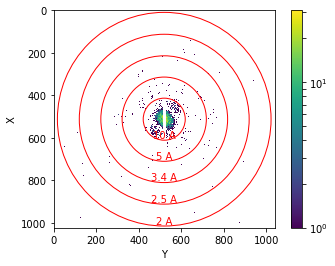

In [14]:
demo(experiment)